In [1]:
import coinmetrics
import numpy as np
import datetime as dt
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pca import pca
from sklearn import preprocessing
from scipy import stats
from scipy.cluster import hierarchy

plt.rcParams["figure.figsize"] = (20,10)

In [5]:
cm = coinmetrics.Community()
moneda = 'btc'
available_data_types = cm.get_available_data_types_for_asset(moneda)

metrica = "AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,\
FeeMeanUSD,FeeMedNtv,FeeMedUSD,FeeTotNtv,FeeTotUSD,HashRate,IssContNtv,IssContPctAnn,IssContUSD,IssTotNtv,IssTotUSD,\
NVTAdj,NVTAdj90,PriceBTC,PriceUSD,ROI1yr,ROI30d,SplyCur,SplyExpFut10yrCMBI,SplyFF,TxCnt,TxTfrCnt,TxTfrValAdjNtv,\
TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,\
VtyDayRet30d,VtyDayRet60d"

begin_timestamp = "2000-01-01"
end_timestamp = '2020-11-28'
asset_data = cm.get_asset_data_for_time_range(moneda, metrica ,begin_timestamp, end_timestamp)

In [3]:
start_time = time.time()
db = coinmetrics.cm_to_pandas(asset_data)
db.index = np.arange(len(db))
db = db.interpolate(method='polynomial', order=2)
end_time = time.time()
print("Segundos", end_time - start_time)

Segundos 0.4197380542755127


In [4]:
for name in db.columns:
    db[name] = db[name].fillna(0)    

In [5]:
Q1 = db.quantile(0.25)
Q3 = db.quantile(0.75)
IQR = Q3 - Q1

db = db[~((db < (Q1 - 1.5 * IQR)) |(db > (Q3 + 1.5 * IQR))).any(axis=1)]

In [6]:
df = pd.DataFrame(db.values)
df.columns = db.columns

In [7]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet

def m_detectOutliers(data, extreme=False):
    robust_cov = MinCovDet().fit(data)
    m = robust_cov.mahalanobis(data)
    # one popular way to specify the threshold
    me = np.mean(m)
    t = 3. * me if extreme else 2. * me
    outliers = []
    for i in range(len(m)):
        if m[i] > t:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

df_wo = df.drop(m_detectOutliers(df, extreme = False))

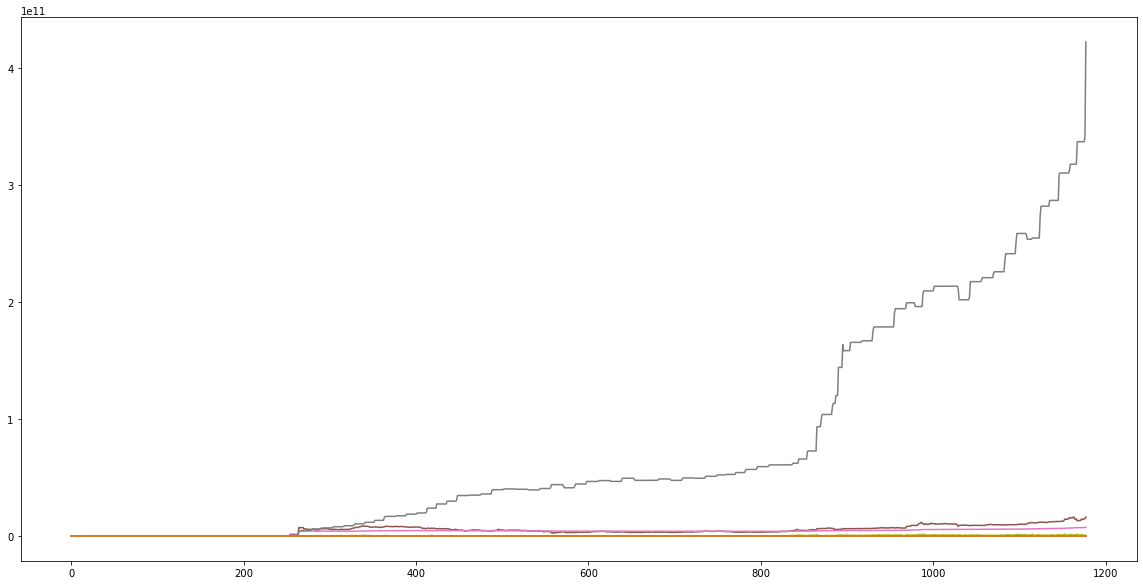

In [8]:
plt.plot(df_wo)
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [10]:
X = df_wo[['AdrActCnt','BlkCnt','BlkSizeByte','BlkSizeMeanByte','CapMVRVCur','CapMrktCurUSD','CapRealUSD','DiffMean','FeeMeanNtv','FeeMeanUSD','FeeMedNtv','FeeMedUSD','FeeTotNtv','FeeTotUSD','HashRate','IssContNtv','IssContPctAnn','IssContUSD','IssTotNtv','IssTotUSD','NVTAdj','NVTAdj90','PriceBTC','ROI1yr','ROI30d','SplyCur','SplyExpFut10yrCMBI','SplyFF','TxCnt','TxTfrCnt','TxTfrValAdjNtv','TxTfrValAdjUSD','TxTfrValMeanNtv','TxTfrValMeanUSD','TxTfrValMedNtv','TxTfrValMedUSD','TxTfrValNtv','TxTfrValUSD','VtyDayRet180d','VtyDayRet30d','VtyDayRet60d']]
y = df_wo['PriceUSD']

X_train, X_test, y_train, y_test = train_test_split(X, y.values.reshape(-1,1), train_size   = 0.8, random_state = 1234, shuffle = True)

In [11]:
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.027e+05
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        20:58:06   Log-Likelihood:                -2592.9
No. Observations:                 942   AIC:                             5258.
Df Residuals:                     906   BIC:                             5432.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AdrActCnt            3.52e-05    6.2

## Eliminamos las variables con p-value < 0.05 ya que no aportan de forma significativa al modelo

## Total **variables restantes 29**

In [12]:
df_regresion_wo = df_wo.drop(['BlkCnt', 'CapMVRVCur', 'FeeMeanNtv', 'FeeMedUSD', 'FeeMedNtv','HashRate','IssContPctAnn','IssTotNtv', 'PriceBTC','SplyExpFut10yrCMBI','TxTfrValMeanNtv','TxTfrValNtv','VtyDayRet60d'], axis=1)

In [13]:
#x = df_wo.values
x = df_regresion_wo.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
#df.columns = df_wo.columns
df.columns = df_regresion_wo.columns

In [14]:
model = pca()
# Fit transform
out = model.fit_transform(df)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [29] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


In [15]:
print(out['topfeat'])

      PC          feature   loading  type
0    PC1  BlkSizeMeanByte  0.291317  best
1    PC2       IssContUSD  0.355479  best
2    PC3           ROI1yr  0.480446  best
3    PC4     VtyDayRet30d  0.795768  best
4    PC5   TxTfrValAdjNtv -0.454336  best
5    PC6   TxTfrValMedUSD  0.695782  best
6    PC7           ROI1yr -0.551104  best
7    PC8       IssContNtv  0.476263  best
8    PC9   TxTfrValMedNtv  0.461005  best
9   PC10         NVTAdj90 -0.499413  best
10  PC11  TxTfrValMeanUSD  0.524004  best
11  PC12    VtyDayRet180d  0.591773  best
12  PC13   TxTfrValMedNtv -0.434607  best
13  PC14           NVTAdj  0.632733  best
14  PC15   TxTfrValAdjNtv -0.413779  best
15  PC16        FeeTotNtv  0.476212  best
16  PC17  BlkSizeMeanByte  0.441469  best
17  PC18         TxTfrCnt  0.772183  best
18  PC19   TxTfrValAdjUSD -0.583926  best
19  PC20        AdrActCnt  0.547518  best
20  PC21            TxCnt  0.604657  best
21  PC22        FeeTotUSD -0.504527  best
22  PC23   TxTfrValAdjUSD  0.48611

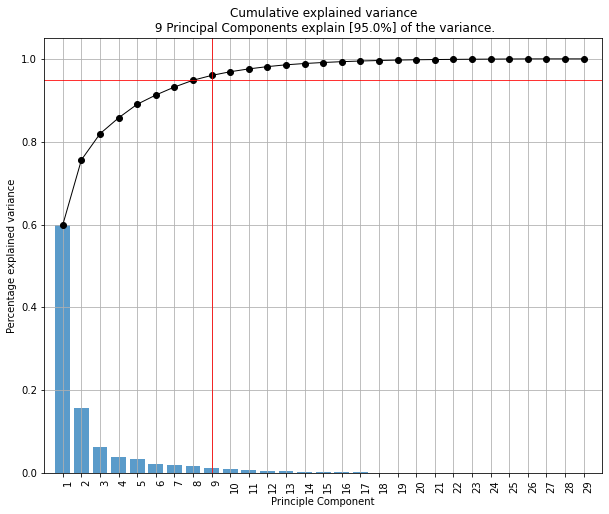

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f566ffb8370>)

<Figure size 1440x720 with 0 Axes>

In [16]:
model.plot()

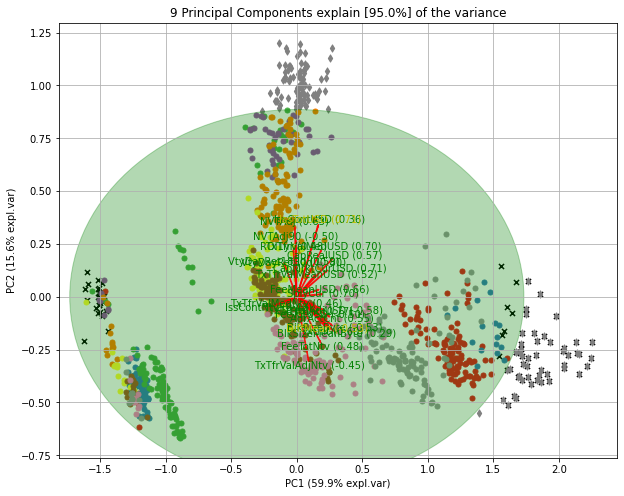

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f566ffb1d60>)

In [17]:
model.biplot(legend=False, SPE=True, hotellingt2=True, label = False)

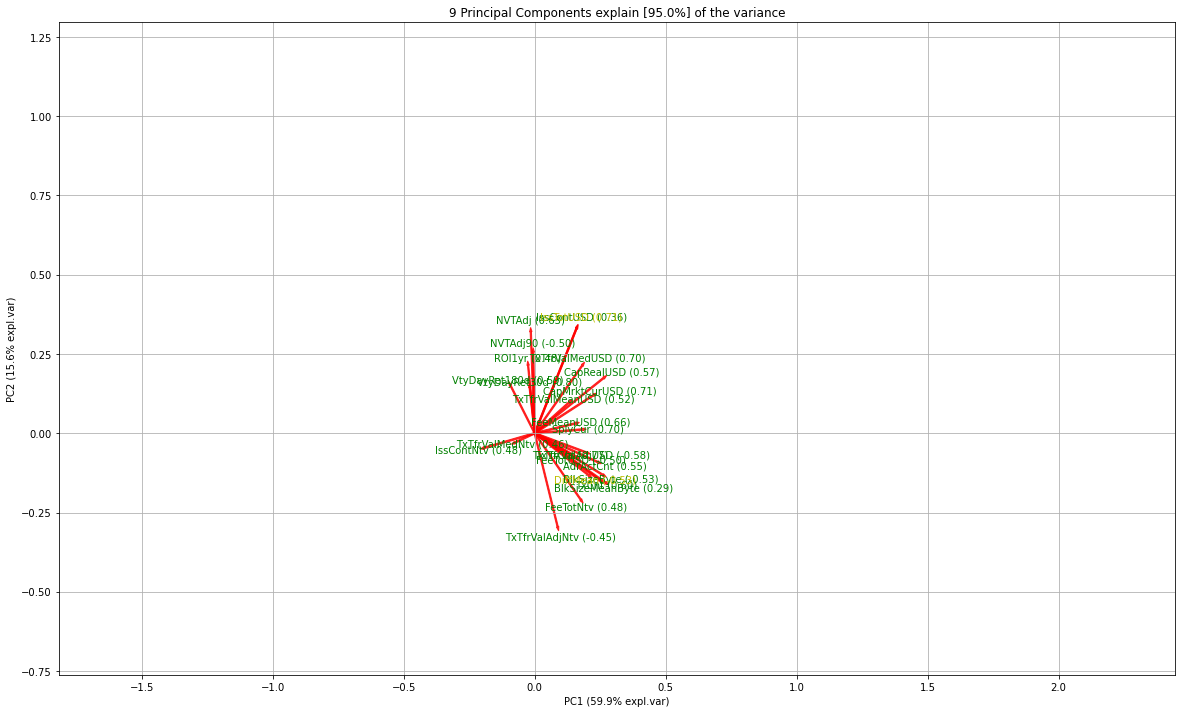

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f566f1ed070>)

In [18]:
model.biplot(cmap=None, label=False, legend=False,figsize=(20,12),visible=True)

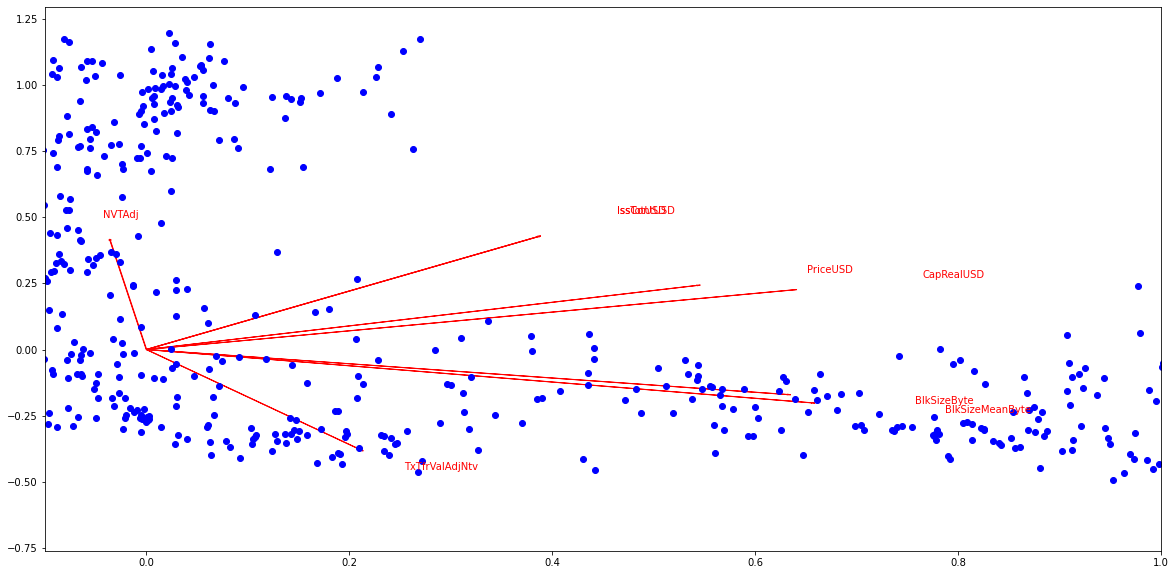

array(['BlkSizeByte', 'BlkSizeMeanByte', 'CapRealUSD', 'IssContUSD',
       'IssTotUSD', 'NVTAdj', 'PriceUSD', 'TxTfrValAdjNtv'], dtype=object)

In [19]:
from sklearn.decomposition import PCA

n = len(df.columns)

pca = PCA(n_components = n)
pca.fit(df)
xvector = pca.components_[0]
yvector = pca.components_[1]
xs = pca.transform(df)[:,0]
ys = pca.transform(df)[:,1]

#print(df.columns.values[14]) #vector priceUSD
#print(xvector[14])
plt.xlim(-0.1,1)
lim = np.sqrt(xvector[14]**2 + yvector[14]**2)
feat = []

for i in range(len(xvector)):
    if(np.sqrt(xvector[i]**2 + yvector[i]**2) >= lim):
    #if(xvector[i] >= lim or yvector[i]>=0.4):
        plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
                  color='r', width=0.0005, head_width=0.0025)
        plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
                 list(df.columns.values)[i], color='r')
        feat.append(i)

for i in range(len(xs)):
    plt.plot(xs[i], ys[i], 'bo')
    #plt.text(xs[i]*1.2, ys[i]*1.2, list(df.index)[i], color='b')

plt.show()
df.columns.values[feat]

## Eliminamos las variables que tienen una norma menor al vector PriceUSD y con distinta dirección

## Total de **variables restantes 7**

In [20]:
df_red = df[df.columns.values[feat]].copy()
df_red = df_red.drop(['NVTAdj'],axis =1)

In [22]:
#Con 29 variables

import dcor
# Create the distance method using distance_correlation
distcorr = lambda column1, column2: dcor.distance_correlation(column1, column2) 
# Apply the distance method pairwise to every column
rslt = df_red.apply(lambda col1: df_regresion_wo.apply(lambda col2: distcorr(col1, col2)))

pd.options.display.float_format = '{:,.2f}'.format
rslt

,BlkSizeByte,BlkSizeMeanByte,CapRealUSD,IssContUSD,IssTotUSD,PriceUSD,TxTfrValAdjNtv
AdrActCnt,0.98,0.96,0.84,0.65,0.65,0.75,0.55
BlkSizeByte,1.00,0.99,0.78,0.60,0.60,0.70,0.58
BlkSizeMeanByte,0.99,1.00,0.77,0.57,0.57,0.68,0.57
CapMrktCurUSD,0.76,0.74,0.90,0.85,0.85,0.99,0.27
CapRealUSD,0.78,0.77,1.00,0.85,0.85,0.89,0.22
DiffMean,0.92,0.91,0.71,0.49,0.49,0.71,0.54
FeeMeanUSD,0.74,0.72,0.78,0.72,0.72,0.92,0.30
FeeTotNtv,0.80,0.79,0.49,0.26,0.26,0.55,0.67
FeeTotUSD,0.84,0.83,0.68,0.48,0.48,0.76,0.48
IssContNtv,0.70,0.72,0.80,0.64,0.64,0.71,0.26


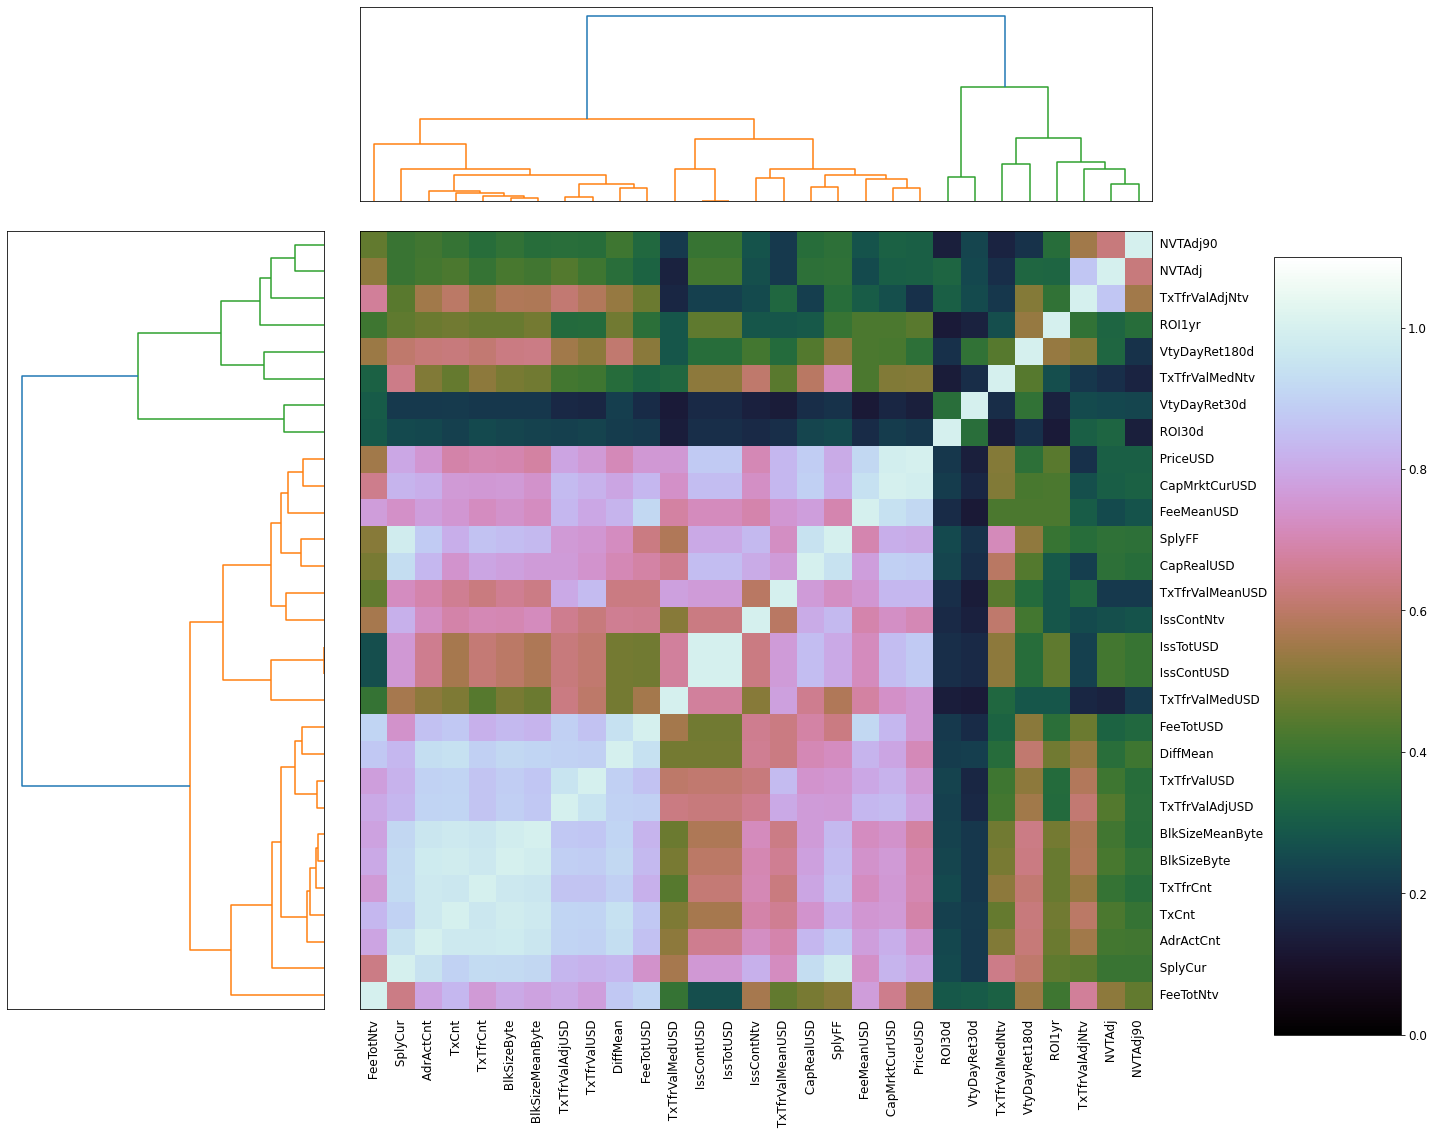

In [30]:
from biokit.viz import heatmap

df_regresion_wo.rename(index=str, columns={"Gross pay transform": "Gross pay tr"}, inplace=True)
distcorr = lambda column1, column2: dcor.distance_correlation(column1, column2)
rslt = df_regresion_wo.apply(lambda col1: df_regresion_wo.apply(lambda col2: distcorr(col1, col2)))
h = heatmap.Heatmap(rslt)
h.plot(vmin=0.0, vmax=1.1, cmap='cubehelix')
fig = plt.gcf()
fig.set_size_inches(22, 18)
plt.gcf().get_axes()[1].invert_xaxis();
plt.savefig('BTC_dendograma.png', dpi = 100)